# TensorflowTTS real time E2E-TTS demonstration

DisfluencyRemover 으로 얻은 영어 텍스트를 더 활용할 방안에 대한 제시입니다.

영어 텍스트를 한국어로 번역하고(적절히 붙일 모델을 찾지 못해 별도로 해야 합니다.),

Pretrained 된 FastSpeech2와 Multi-band MelGAN 을 활용해 이 텍스트를 한국어 음성으로 바꾸어 결과적으로 영어 오디오를 한국어 오디오로 변환할 수 있습니다.

Test 셀에서 직접 input_text에 원하는 문장을 입력하거나, 번역한 text를 text_input_TTS 로 gdrive 에 저장해서 원하는 테스트 블록을 선택해서 진행하시면 됩니다.

## Install

In [19]:
import os
!git clone https://github.com/TensorSpeech/TensorFlowTTS.git
os.chdir("TensorFlowTTS")
!pip install .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

fatal: destination path 'TensorFlowTTS' already exists and is not an empty directory.
Processing /content/TensorFlowTTS
  Created wheel for TensorFlowTTS: filename=TensorFlowTTS-0.0-cp36-none-any.whl size=120926 sha256=bd2e09917c2bb5f4f5ded6bd6b936af29055295818fef6ffc629580789cf8a87
  Stored in directory: /tmp/pip-ephem-wheel-cache-pnox_7g6/wheels/53/fa/a5/6da6cd434ed077f9027135e4143d7acc9e07a34e6aaebcf476
Successfully built TensorFlowTTS
  Found existing installation: TensorFlowTTS 0.0
    Uninstalling TensorFlowTTS-0.0:
      Successfully uninstalled TensorFlowTTS-0.0


## Download pretrained feature generation model


### FastSpeech2

In [20]:
print("Downloading FastSpeech2 model...")
!gdown --id {"1adb_hA9q0Qg959bl70WiRpm5a9Hdc2Ym"} -O fastspeech2-200k.h5

Downloading...
From: https://drive.google.com/uc?id=1adb_hA9q0Qg959bl70WiRpm5a9Hdc2Ym
To: /content/fastspeech2-200k.h5
125MB [00:00, 203MB/s]


## Download pretrained Vocoder model


### Multi-band MelGAN

In [21]:
print("Downloading Multi-band MelGAN model...")
!gdown --id {"1tmmUjKIFekzlQi0-BmEcrib_QP2QbChY"} -O mb.melgan-1000k.h5

Downloading...
From: https://drive.google.com/uc?id=1tmmUjKIFekzlQi0-BmEcrib_QP2QbChY
To: /content/mb.melgan-1000k.h5
10.2MB [00:00, 62.5MB/s]


## Load Model

In [22]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

### FastSpeech2

In [23]:
fastspeech2_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/fastspeech2/conf/fastspeech2.kss.v1.yaml')
fastspeech2 = TFAutoModel.from_pretrained(
    config=fastspeech2_config,
    pretrained_path="fastspeech2-200k.h5",
    name="fastspeech2"
)

### Multi-band MelGAN

In [24]:
mb_melgan_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/multiband_melgan/conf/multiband_melgan.v1.yaml')
mb_melgan = TFAutoModel.from_pretrained(
    config=mb_melgan_config,
    pretrained_path="mb.melgan-1000k.h5",
    name="mb_melgan"
)

## Inference
- The first time model run inference will very slow cause by @tf.function.

In [25]:
print("Downloading kss_mapper.json...")
!gdown --id {"1MO1IYKZYUCg3Ve3Gs8iF2pFGCNSFE-da"} -O kss_mapper.json

Downloading...
From: https://drive.google.com/uc?id=1MO1IYKZYUCg3Ve3Gs8iF2pFGCNSFE-da
To: /content/kss_mapper.json
100% 2.37k/2.37k [00:00<00:00, 3.60MB/s]


In [26]:
processor = AutoProcessor.from_pretrained(pretrained_path="./kss_mapper.json")

In [27]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MB-MELGAN":
    audio = vocoder_model.inference(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

# TEST 1. 문장을 직접 입력해서 확인

In [35]:
input_text = "콘볼루션 신경 네트워크는 깊은 신경 네트워크의 한 종류다."

### FastSpeech2 + MB-MELGAN

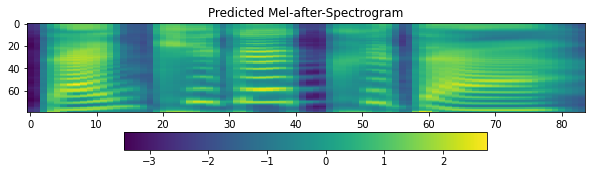

In [36]:
mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

# TEST 2. 번역한 텍스트를 입력받아 확인

In [42]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

file_path = '/gdrive/My Drive/text_input_TTS.txt'
f = open(file_path, 'r')
input_texts = f.readlines()
f.close()

print(input_texts)

Mounted at /gdrive
['콘볼루션 신경 네트워크는 깊은 신경 네트워크의 한 종류다.\n', '오늘 수업은 이것에 대해 배울 예정이다.\n', '아래 주석처리 된 것 처럼 포문으로 돌리고 싶지만, 코랩이라 여러 출력을 따로 따로 보여주기 어려웠다.\n', '그래서 각 문장마다 출력하는 것이 좋겠다.']


### FastSpeech2 + MB-MELGAN

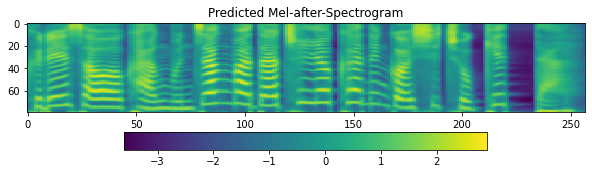

In [43]:
#for i in range(len(input_texts)):

input_text = input_texts[i] #i is the index of sentence that you want to convert

mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)